This builds on the geeet-analysis notebook to do some analysis on the exported csv from that notebook.

In [ ]:
#imports all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import metloom as mt

# Load the exported CSV data
df = pd.read_csv(r"C:\School\GITHUB RESPOSITORIES\thesis\data\DC_ET_zonalstats.csv")

In [ ]:
#check the first few rows of the data
df.head()

In [ ]:
#pad zone_id with leading zeros that got lost during export
df['zone_id_str'] = df['zone_id'].apply(lambda x: str(int(x)).zfill(7))
df

In [ ]:
#set the datetime as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# sort by index
df.sort_index(inplace=True)
df.head()

In [ ]:
#pivot the data to have zone_ids as columns and months as rows, with mean ET values

pivot_mean = df.pivot_table(
    index='datetime',          # each row = one datetime
    columns='zone_id',       # each column = one zone_id
    values='mean_ET',         # values to fill
    fill_value=None              # keeps missing values as NaN
)

# Create a full monthly date range that has missing months included
full_index = pd.date_range(
    start=pivot_mean.index.min(),
    end=pivot_mean.index.max(),
    freq='MS'  # Month Start
)

pivot_mean = pivot_mean.reindex(full_index)

#add attributes to the pivoted dataframe to make zone_id readable
# Take one row per zone for attributes
zone_attrs = df.drop_duplicates(subset='zone_id')[['zone_id','aspect_class','elev_class','slope_class','nlcd']]

print(pivot_mean.shape)
print(df['zone_id'].nunique())

#merge attributes with pivoted dataframe
pivot_mean.attrs = zone_attrs.set_index('zone_id').to_dict(orient='index')
pivot_mean.attrs



In [ ]:
#label classes with readable names

# Aspect → 8 bins of 45 degrees
aspect_labels = {
    0: "N-NE (0-45°)",
    1: "NE-E (45-90°)",
    2: "E-SE (90-135°)",
    3: "SE-S (135-180°)",
    4: "S-SW (180–225°)",
    5: "SW-W (225-270°)",
    6: "W-NW (270-315°)",
    7: "NW-N (315-360°)"
}

# Slope bins exactly from your GEE expression
slope_labels = {
    0: "0–5°",
    1: "5–15°",
    2: "15–25°",
    3: "25–35°",
    4: "35°+"
}

# NLCD: leave as numeric unless you want full NLCD dictionary
nlcd_labels = {   # a few common ones; add more if needed
    11: "Open Water",
    21: "Developed Open Space",
    22: "Developed Low Intensity",
    23: "Developed Medium Intensity",
    24: "Developed High Intensity",
    31: "Barren",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Grassland",
    81: "Pasture",
    82: "Cultivated",
    90: "Woody Wetlands",
    95: "Emergent Wetlands"
}

elev_labels = {
    0: "Low",
    1: "Medium-Low",
    2: "Medium",
    3: "Medium-High",
    4: "High"
}

#Elevation bin 0: 1033.1241455078125 to 1251.6919921875
#Elevation bin 1: 1251.6919921875 to 1470.2598388671877
#Elevation bin 2: 1470.2598388671875 to 1688.827685546875
#Elevation bin 3: 1688.827685546875 to 1907.3955322265626
#Elevation bin 4: 1907.3955322265624 to 2125.96337890625


In [ ]:
def build_lookup(df):
    lookup = df[['zone_id','aspect_class','elev_class','slope_class','nlcd']]\
                .drop_duplicates(subset='zone_id')\
                .copy()

    lookup["aspect_label"] = lookup["aspect_class"].map(aspect_labels)
    lookup["slope_label"] = lookup["slope_class"].map(slope_labels)
    lookup["elev_label"]  = lookup["elev_class"].map(elev_labels)
    lookup["nlcd_label"]  = lookup["nlcd"].map(nlcd_labels).fillna("Other")

    return lookup

lookup = build_lookup(df)
lookup.head()

# Optional: create a combined label
lookup['combined_label'] = lookup.apply(
    lambda x: f"{x['aspect_label']} | {x['elev_label']} | {x['nlcd_label']} | {x['slope_label']}", axis=1
)

lookup.head()


In [31]:
# ----------------------------
# Define a function to plot ET time series for given zone IDs
# ----------------------------
def plot_monthly_timeseries(pivot_df, lookup, agg_attrs,start_date=None, end_date=None):
    """
    Plot ET monthly time series aggregated by any class combination.
    Gaps in months appear as breaks in the lines.
    
    pivot_df : DataFrame, index=datetime, columns=zone_id
    lookup   : DataFrame with labels per zone_id
    agg_attrs: list of columns in lookup to aggregate by
    """
    # ---- Optional datetime filtering ----
    if start_date is not None or end_date is not None:
        # Ensure datetime index
        if not np.issubdtype(pivot_df.index.dtype, np.datetime64):
            pivot_df.index = pd.to_datetime(pivot_df.index)

        # Apply filtering
        if start_date is not None:
            pivot_df = pivot_df[pivot_df.index >= pd.to_datetime(start_date)]
        if end_date is not None:
            pivot_df = pivot_df[pivot_df.index <= pd.to_datetime(end_date)]

    # ---- Build combined readable label ----
    lookup['agg_label'] = lookup[agg_attrs].astype(str).agg(" | ".join, axis=1)

    # ---- Map zone_id → agg_label ----
    col_labels = [
        lookup.loc[lookup['zone_id'] == z, 'agg_label'].values[0]
        for z in pivot_df.columns
    ]

    df_plot = pivot_df.copy()
    df_plot.columns = col_labels

    # ---- Aggregate by class combination ----
    df_plot = df_plot.groupby(df_plot.columns, axis=1).mean()

    # ---- Resample monthly (ensures gaps become NaN) ----
    df_plot = df_plot.resample("M").mean()

    # ---- Plot ----
    plt.figure(figsize=(14,6))
    for c in df_plot.columns:
        plt.plot(df_plot.index, df_plot[c], marker=None, label=c)

    plt.ylabel("ET (mm)")
    plt.xlabel("Month")
    plt.title(f"Monthly Mean Daily ET aggregated by {', '.join(agg_attrs)}")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()


C:\Users\maxwe\AppData\Local\Temp\ipykernel_19352\2669880686.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_plot = df_plot.groupby(df_plot.columns, axis=1).mean()
C:\Users\maxwe\AppData\Local\Temp\ipykernel_19352\2669880686.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_plot = df_plot.resample("M").mean()


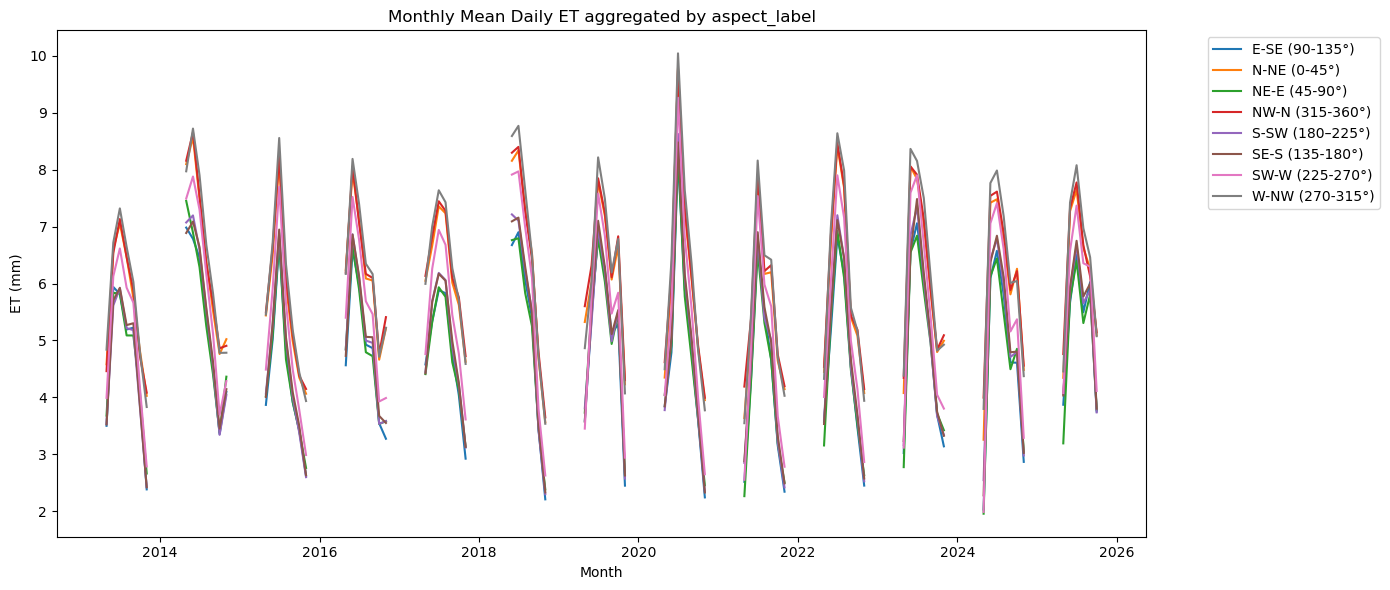

In [41]:
plot_monthly_timeseries(pivot_mean, lookup, ['aspect_label'])

In [ ]:
# ----------------------------
# Define a function to plot mean over all years by attributes
# ----------------------------
def plot_mean_monthly_over_years(pivot_df, lookup, agg_attrs):
    """
    Plot long-term mean monthly ET aggregated by any class/class combination.
    Gaps automatically handled.
    """

    # ---- Apply readable labels ----
    lookup['agg_label'] = lookup[agg_attrs].astype(str).agg(" | ".join, axis=1)

    col_labels = [
        lookup.loc[lookup['zone_id'] == z, 'agg_label'].values[0]
        for z in pivot_df.columns
    ]

    df_plot = pivot_df.copy()
    df_plot.columns = col_labels

    # ---- Aggregate by label ----
    df_plot = df_plot.T.groupby(df_plot.columns).mean().T

    # ---- Resample monthly (ensure 12 months present) ----
    monthly = df_plot.resample("ME").mean()

    # ---- Extract month number ----
    monthly['month'] = monthly.index.month

    # ---- Long-term mean for each calendar month ----
    climatology = monthly.groupby('month').mean()

    # ---- Plot ----
    plt.figure(figsize=(10,6))
    for c in climatology.columns:
        plt.plot(climatology.index, climatology[c], marker='o', label=c)

    plt.xlabel("Month")
    plt.ylabel("Mean Daily ET (mm)")
    plt.xticks(range(1,13))
    plt.title(f"Monthly Mean Daily ET (all years) aggregated by {', '.join(agg_attrs)}")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left",)
    plt.tight_layout()
    plt.show()


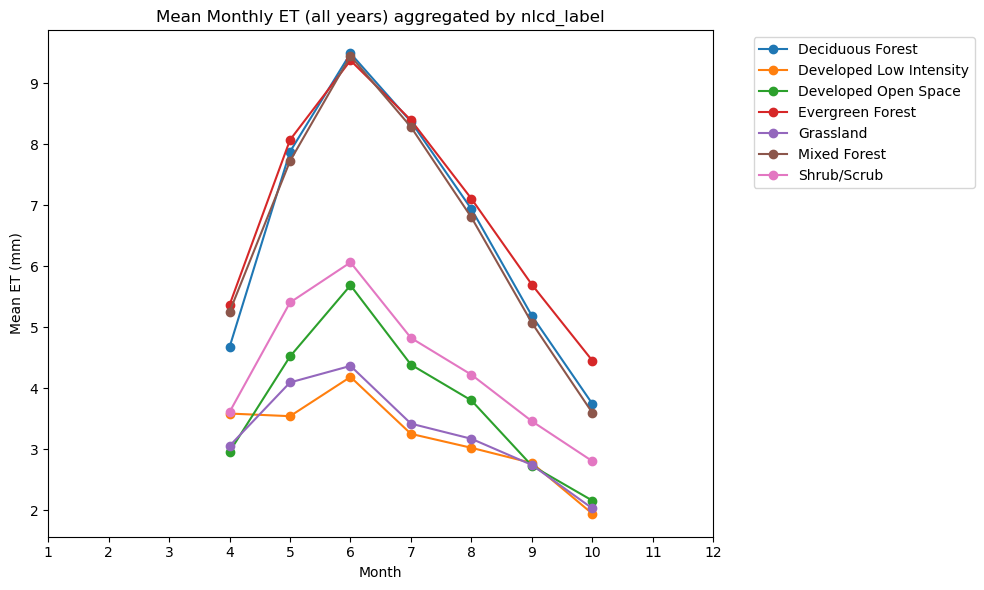

In [45]:
plot_mean_monthly_over_years(pivot_mean, lookup, ['nlcd_label'])

Now let's add streamflow data from the Dry Creek Lower Gauge to see if we can see any patterns 

In [ ]:
import os
import glob
# Load streamflow data from multiple Excel files
folder_path = r"C:\School\thesis_stuff\DC_streamflow\lower_gauge"
all_files = glob.glob(os.path.join(folder_path, "*.xlsx"))

In [64]:
#------------------
#Load streamflow data from excel files
#------------------
import os
import glob

excel_folder = r"C:\School\thesis_stuff\DC_streamflow\lower_gauge"
all_files = glob.glob(os.path.join(excel_folder, "*.csv"))  

dfs = []

for file in all_files:
    # Adjust skiprows to match the number of descriptive rows at the top
    df = pd.read_csv(file, skiprows=18)  # e.g., first 6 rows are text
     
    # Rename columns for convenience
    df = df.rename(columns={
        'DateTime': 'DateTime',
        'Discharge -L/s': 'Discharge L/s',
        'StreamTemp-C': 'StreamTemp_C',
        'StreamEC-mS/cm': 'StreamEC_mScm'
    })
    
    # Parse datetime column
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed')
    
    # Set datetime as index
    df = df.set_index('DateTime')
    
    # Convert missing data code (-6999) to NaN
    df = df.replace([-6999, '#NUM!', '#DIV/0!', ''],np.nan)
    pd.to_numeric(df['Discharge-L/s'], errors='coerce')
    
    dfs.append(df)

# Combine all files into one DataFrame
streamflow_df = pd.concat(dfs).sort_index()

print(streamflow_df)


                    Discharge-L/s  StreamTemp_C  StreamEC_mScm
DateTime                                                      
2013-01-01 00:00:00         43.27           1.5          0.175
2013-01-01 01:00:00        44.527           1.5          0.176
2013-01-01 02:00:00        45.811           1.5          0.178
2013-01-01 03:00:00        50.284           1.5          0.178
2013-01-01 04:00:00        50.284           1.5          0.178
...                           ...           ...            ...
2022-12-31 19:00:00        133.58           2.8          0.257
2022-12-31 20:00:00        132.63           2.7          0.259
2022-12-31 21:00:00        132.63           2.5          0.261
2022-12-31 22:00:00        130.75           2.4          0.264
2022-12-31 23:00:00        128.88           2.2          0.267

[87648 rows x 3 columns]


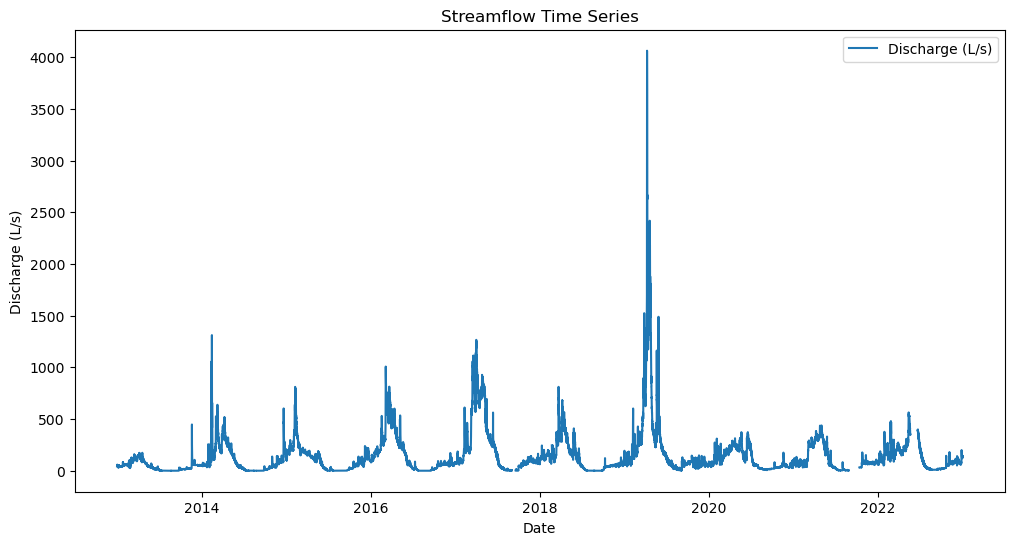

In [66]:

# Convert to numeric, coercing any errors to NaN
streamflow_df['Discharge-L/s'] = pd.to_numeric(streamflow_df['Discharge-L/s'], errors='coerce')
#Make negative streamflow values NaN
streamflow_df['Discharge-L/s'] = streamflow_df['Discharge-L/s'].apply(lambda x: x if x >= 0 else np.nan)

#Plot streamflow data to check it

plt.figure(figsize=(12,6))
plt.plot(streamflow_df.index, streamflow_df['Discharge-L/s'], label='Discharge (L/s)')
plt.xlabel('Date')
plt.ylabel('Discharge (L/s)')
plt.title('Streamflow Time Series')
plt.legend()
plt.show()

In [79]:
#Plot streamflow data alongside ET data for comparison

def plot_agg_et_and_streamflow_(pivot_df, lookup, agg_attrs, streamflow_df):
    """
    Calls your existing ET time series function and then adds streamflow as a bottom subplot.
    
    pivot_df       : ET pivot table (datetime index, zone_id columns)
    lookup         : lookup table for zone_id labels
    agg_attrs      : list of attributes to aggregate ET
    streamflow_df  : cleaned streamflow dataframe (datetime index, 'Discharge-L/s')
    """

    # ---- Create figure with 2 stacked subplots ----
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14,8), gridspec_kw={'height_ratios':[2,1]})

    # ---- Plot ET on the top axis ----
    # Make a copy so your function doesn’t modify the original
    pivot_copy = pivot_df.copy()
    
    # Modify your function slightly to take an optional `ax` argument
    # Or, just temporarily redirect plt to ax1
    plt.sca(ax1)  # Set current axis to ax1
    plot_monthly_timeseries(pivot_copy, lookup, agg_attrs)
    ax1.set_title("ET and Streamflow Time Series (top: ET, bottom: Streamflow)")

    # ---- Plot Streamflow on the bottom axis ----
    ax2.plot(streamflow_df.index, streamflow_df['Discharge-L/s'], color='tab:blue', linewidth=1)
    ax2.set_ylabel("Discharge (L/s)")
    ax2.set_xlabel("Date")
    
    plt.tight_layout()
    plt.show()

#Function to plot monthly ET (not class aggregated) and streamflow
def plot_et_and_streamflow(pivot_df, streamflow_df):
    """
    Plot overall monthly ET and streamflow on the same datetime x-axis.
    Top: ET (averaged across all zones)
    Bottom: Streamflow
    
    pivot_df       : DataFrame, index=datetime, columns=zone_id
    streamflow_df  : DataFrame, index=datetime, column='Discharge-L/s'
    """
    # Compute overall ET across all zones
    overall_et = pivot_df.mean(axis=1, skipna=True)

    # Align the datetime index of both dataframes
    # This ensures the x-axis is shared properly
    combined_index = overall_et.index.union(streamflow_df.index)
    overall_et = overall_et.reindex(combined_index)
    streamflow = streamflow_df['Discharge-L/s'].reindex(combined_index)

    # Create figure with two subplots
    fig, ax1 = plt.subplots(figsize=(12,6))

    # ET line (monthly points connected)
    ax1.plot(overall_et.index, overall_et, marker=None, linestyle='-', color='tab:green', label='ET')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('ET (mm)', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')

    # Secondary y-axis for streamflow
    ax2 = ax1.twinx()
    ax2.plot(streamflow_df.index, streamflow_df['Discharge-L/s'], color='tab:blue', label='Discharge')
    ax2.set_ylabel('Discharge (L/s)', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Title and legend
    fig.tight_layout()
    fig.suptitle("Monthly ET and Streamflow Time Series", y=1.02)
    fig.legend(loc='upper right')
    plt.show()



In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))

# ET line (monthly points connected)
ax1.plot(pivot_mean.index, pivot_mean['mean_ET'].mean(axis=1), marker='o', linestyle='-', color='tab:green', label='ET')
ax1.set_xlabel('Date')
ax1.set_ylabel('ET (mm)', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

# Secondary y-axis for streamflow
ax2 = ax1.twinx()
ax2.plot(streamflow_df.index, streamflow_df['Discharge-L/s'], color='tab:blue', label='Discharge')
ax2.set_ylabel('Discharge (L/s)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and legend
fig.tight_layout()
fig.suptitle("Monthly ET and Streamflow Time Series", y=1.02)
fig.legend(loc='upper right')
plt.show()


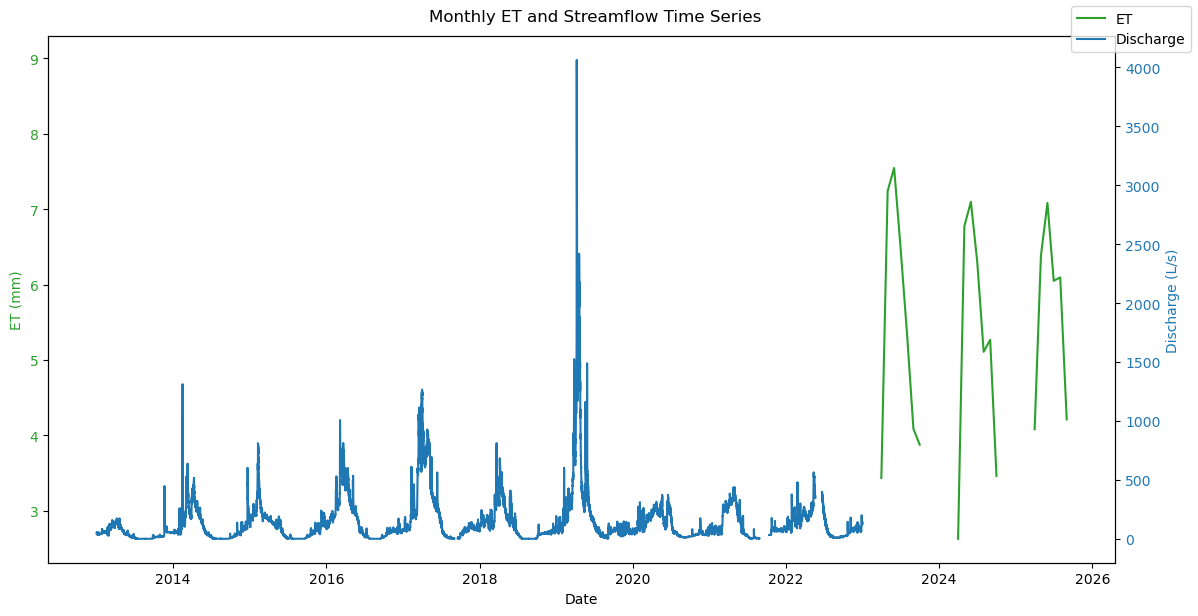

In [80]:
plot_et_and_streamflow(pivot_mean, streamflow_df)

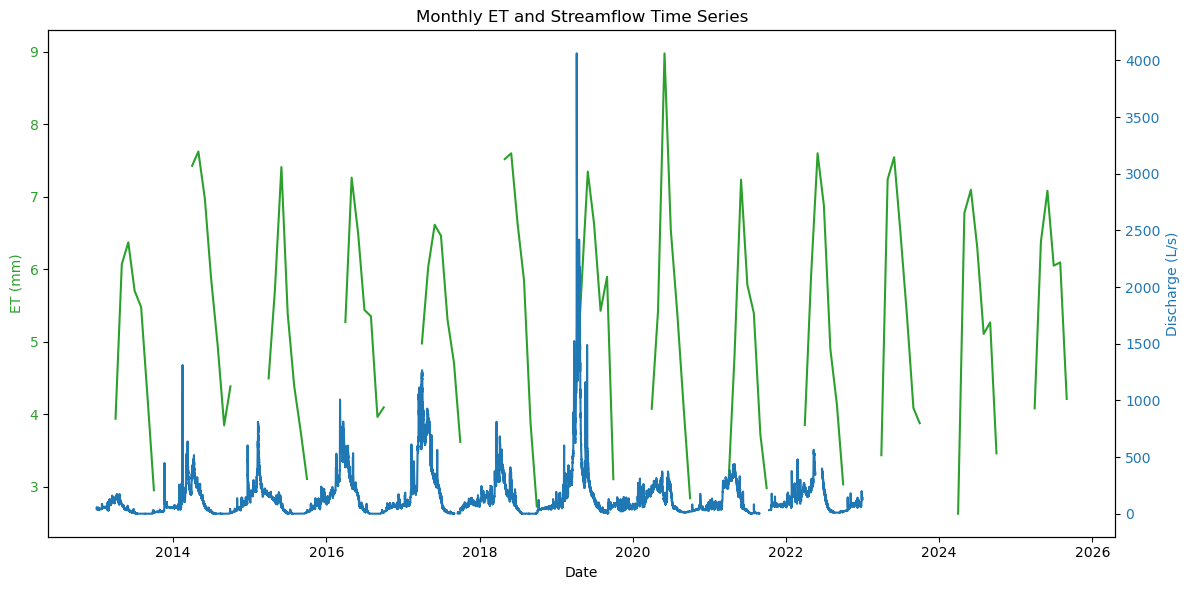

In [83]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot ET as a line connecting monthly points
ax1.plot(
    pivot_mean.index,                  # ET datetime values
    pivot_mean.mean(axis=1),  # aggregated ET
    linestyle='-', 
    color='tab:green', 
    label='ET'
)
ax1.set_xlabel('Date')
ax1.set_ylabel('ET (mm)', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

# Plot streamflow on secondary y-axis, its own index
ax2 = ax1.twinx()
ax2.plot(
    streamflow_df.index, 
    streamflow_df['Discharge-L/s'], 
    color='tab:blue', 
    label='Discharge'
)
ax2.set_ylabel('Discharge (L/s)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title("Monthly ET and Streamflow Time Series")
fig.tight_layout()
plt.show()
